# Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

# Imports

In [278]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import plotly_express as px
import plotly.graph_objects as go
from IPython.display import Image

In [214]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

## Read

In [215]:
df = pd.read_csv("./data/housing.csv")
df.rename(columns={"median_house_value": "median_price"}, inplace=True)
# display(df.head())
# display(df.info())

## Drop Nulls

In [216]:
n_in = len(df)
df.dropna(inplace=True)
n_kept = len(df)
n_dropped = n_in - n_kept
print(
    "Data Frame size in = %d, dropped = %d, retained = %d (%.2f%% dropped, retained %.2f%%)"
    % (n_in, n_dropped, n_kept, n_dropped / n_in * 100.0, n_kept / n_in * 100.0)
)

Data Frame size in = 20640, dropped = 207, retained = 20433 (1.00% dropped, retained 99.00%)


In [217]:
display(df.head())
display(df.info())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_price        20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


None

In [263]:
df = df.query("median_price < 500000 and median_income < 8.0")

In [264]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_price
count,19204.000000,19204.000000,19204.000000,19204.000000,19204.000000,19204.000000,19204.000000,19204.000000,19204.000000
mean,-119.565591,35.658132,28.461310,2609.529577,540.460008,1441.184337,501.636117,3.608576,189486.372422
std,2.006046,2.152643,12.481083,2166.320847,422.201205,1141.288906,382.815018,1.452255,94705.348431
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.760000,33.930000,18.000000,1438.000000,298.000000,798.000000,282.000000,2.516350,115600.000000
50%,-118.510000,34.270000,29.000000,2104.000000,437.000000,1180.000000,411.000000,3.420650,171900.000000
75%,-118.000000,37.730000,37.000000,3108.000000,648.000000,1745.000000,606.000000,4.531300,244100.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,7.997700,499100.000000


# Just for Fun: Scatter of lat x long colored by Ocean Proximity

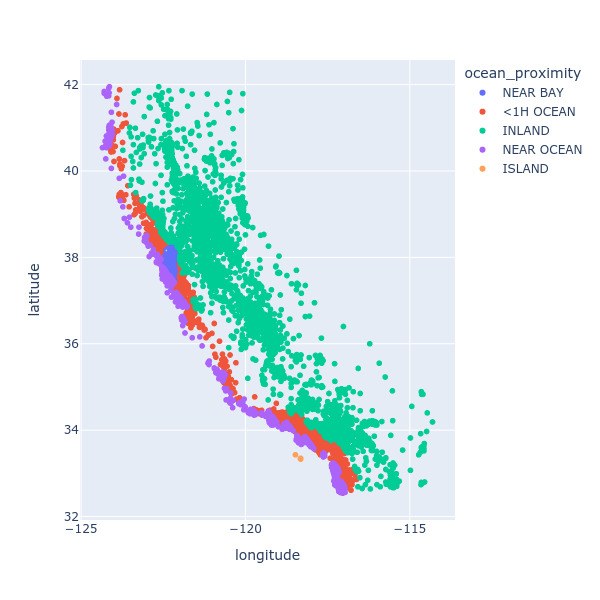

In [242]:
Image(
    px.scatter(df, x="longitude", y="latitude", color="ocean_proximity").to_image(
        format="png", width=600, height=600, scale=1
    )
)

# Looking at Price by Ocean Proximity

Assume price tracks with ocean distance (i.e. ocean proximity is *ordinal*), but let's check that  

Note only 5 data points from island

In [255]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     8496
INLAND        6468
NEAR OCEAN    2410
NEAR BAY      2069
ISLAND           5
Name: count, dtype: int64

In [220]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

## Plots of Price vs. Ocean Proximity

### Boxen

Near bay, near ocean, and within 1 hour of ocean pretty smooshed together, so not ordinal

<Axes: xlabel='ocean_proximity', ylabel='median_price'>

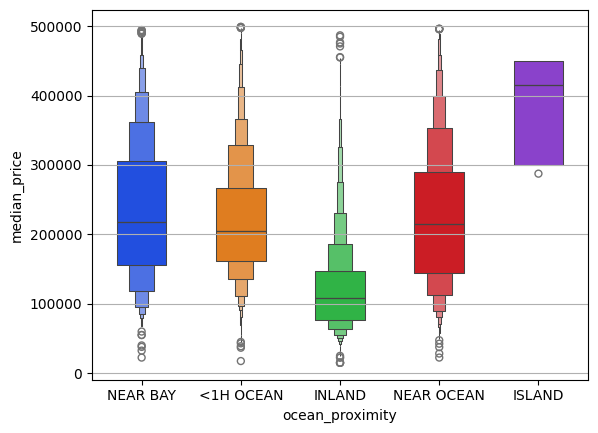

In [265]:
sns.boxenplot(
    data=df,
    x="ocean_proximity",
    y="median_price",
    width=0.5,
    palette="bright",
)

### Bar Plot

#### Calculate mean and median price grouped by proximity to ocean

In [266]:
avg_price_by_ocean = (
    df.groupby("ocean_proximity")
    .agg(
        avg_median_price=("median_price", "mean"),
        med_median_price=("median_price", "median"),
        count=("median_price", "count"),
    )
    .reset_index()
    .apply(round)
    .sort_values(by="med_median_price", ascending=True)
)

display(avg_price_by_ocean)

,ocean_proximity,avg_median_price,med_median_price,count
1,INLAND,121902.0,108000.0,6427
0,<1H OCEAN,220575.0,205100.0,8342
4,NEAR OCEAN,225142.0,215550.0,2394
3,NEAR BAY,233058.0,218100.0,2036
2,ISLAND,380440.0,414700.0,5


#### Plot it

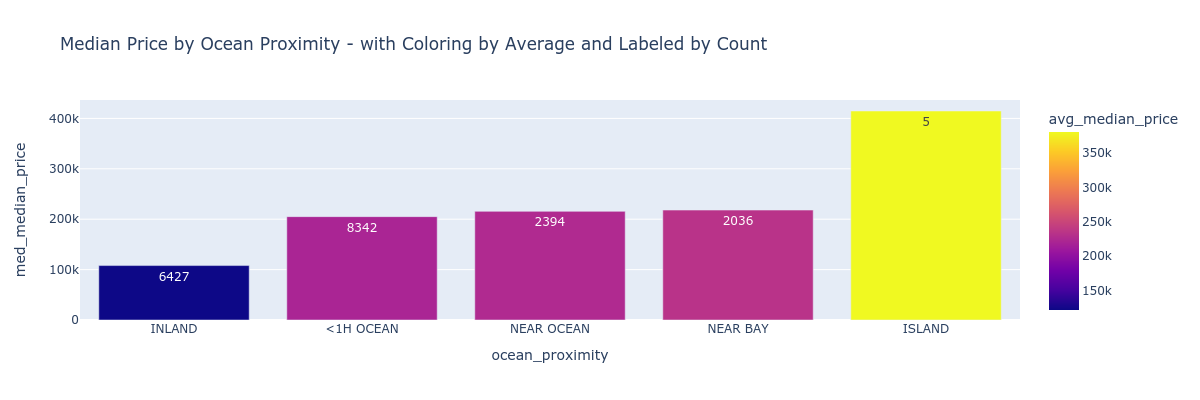

In [267]:
fig = px.bar(
    avg_price_by_ocean,
    x="ocean_proximity",
    y="med_median_price",
    text="count",
    color="avg_median_price",
    title="Median Price by Ocean Proximity - with Coloring by Average and Labeled by Count",
)

# fig.show()
Image(fig.to_image(format="png", width=1200, height=400, scale=1))

## Conclusion - Ocean Proximity Not Ordinal

### Perform the replacement

And drop island because only 5 points

In [225]:
df_ocean = df.copy(deep=True).query("ocean_proximity != 'ISLAND'")
df_ocean["ocean_proximity"].replace(
    ["NEAR OCEAN", "NEAR BAY"],
    "NEAR OCEAN or BAY",
    inplace=True,
)
df_ocean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR OCEAN or BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR OCEAN or BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR OCEAN or BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR OCEAN or BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR OCEAN or BAY


In [269]:
df_ocean["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     8342
INLAND        6427
NEAR OCEAN    2394
NEAR BAY      2036
ISLAND           5
Name: count, dtype: int64

In [270]:
df_ocean["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [268]:
df_ocean = df.copy(deep=True)

# What Correlates with Price?

Income does

## Look at Correlation vs. Price

In [271]:
df_ocean.corr(numeric_only=True)["median_price"].sort_values(ascending=False)

median_price          1.000000
median_income         0.626634
total_rooms           0.136223
households            0.098980
housing_median_age    0.085457
total_bedrooms        0.079913
population            0.012542
longitude            -0.049145
latitude             -0.149922
Name: median_price, dtype: float64

## Scatter of Price vs. Income

Looks like price is hard-limited to 500k

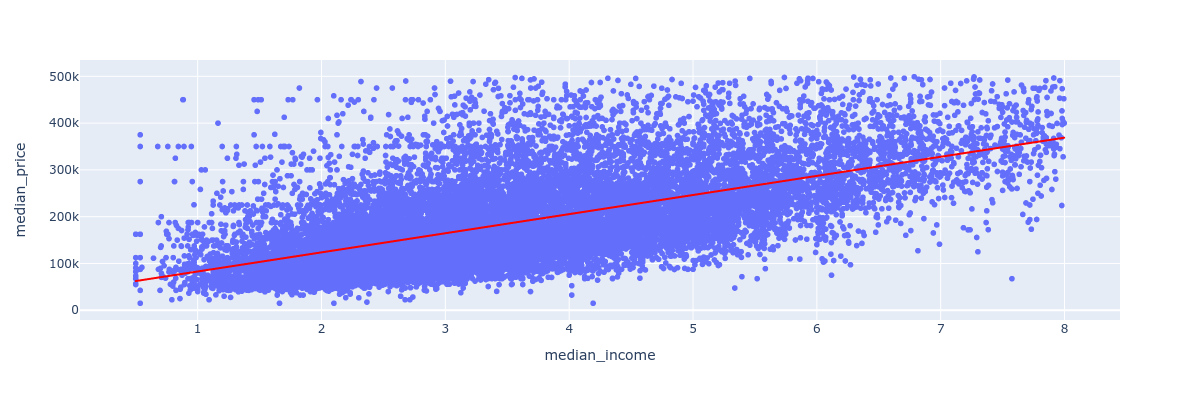

In [272]:
Image(
    px.scatter(
        df_ocean,
        x="median_income",
        y="median_price",
        trendline="ols",
        trendline_color_override="red",
    ).to_image(format="png", width=1200, height=400, scale=1)
)

# Regression Modeling

## Scale

To prevent higher-order evals from saturating 64-bit floats

In [273]:
target_name = "median_price"
df_fit = df_ocean.drop(columns=target_name)
numeric_columns = df_fit.columns[df_fit.dtypes != "object"]

df_fit[numeric_columns] = (
    df_fit[numeric_columns] - df_fit[numeric_columns].mean()
) / df_fit[numeric_columns].std()

# df_fit.describe()
df_fit.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2,-1.333175,1.018222,1.885949,-0.527406,-0.830078,-0.828173,-0.848023,2.512523,NEAR BAY
3,-1.338160,1.018222,1.885949,-0.616497,-0.723494,-0.773848,-0.738310,1.400941,NEAR BAY
4,-1.338160,1.018222,1.885949,-0.453548,-0.616910,-0.767715,-0.633821,0.163624,NEAR BAY
5,-1.338160,1.018222,1.885949,-0.780369,-0.775602,-0.900898,-0.806228,0.294868,NEAR BAY
6,-1.338160,1.013577,1.885949,-0.034404,-0.121885,-0.304204,0.032297,0.034790,NEAR BAY


## Split

75% for training and 25% for development. No holdout set

In [274]:
(X_train, X_dev, y_train, y_dev) = train_test_split(
    df_fit,
    df_ocean[target_name],
    random_state=123,
    test_size=0.25,
)

display([X_train.shape, X_dev.shape])

[(14403, 9), (4801, 9)]

In [275]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12844,-0.899486,1.403795,0.443767,-0.703280,-0.837184,-0.681847,-0.814065,-0.207385,INLAND
2170,-0.161716,0.525804,-1.879749,0.559229,0.389719,0.646476,0.502498,0.119486,INLAND
7581,0.665783,-0.821377,-0.998416,1.104855,1.514775,2.369090,1.717184,-1.011996,<1H OCEAN
5142,0.645843,-0.788859,1.084737,-0.837147,-0.799287,-0.652056,-0.848023,-1.082163,<1H OCEAN
14067,1.219110,-1.350959,-0.277324,-0.178888,0.221553,-0.364662,0.173358,-1.355531,NEAR OCEAN


## Baseline the Model Using Simple Linear Fit

Linear function of income

In [280]:
model_baseline = LinearRegression(fit_intercept=True).fit(
    X_train[["median_income"]], y_train
)

baseline_rmse = root_mean_squared_error(
    y_train, model_baseline.predict(X_train[["median_income"]])
)

baseline_rmse

74137.51689327722

## Make a Fully-Featured Model

### Loop over Polynomial Degree

In [237]:
def clip(x):
    return np.clip(x, 0.0, 500.0e3)

In [282]:
features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    # "households",
    "median_income",
    "ocean_proximity",
]

train_rmses = []
dev_rmses = []
degrees = list(range(1, 4))

for degree in degrees:
    # Make column transformer: one-hot for the ocean proximity and poly features for everything else
    xformer = make_column_transformer(
        (OneHotEncoder(), ["ocean_proximity"]),
        (
            PolynomialFeatures(degree=degree),
            make_column_selector(dtype_include=np.number),
        ),
    )

    # Build the pipeline and fit
    pipe = Pipeline(
        [
            ("transform", xformer),
            ("regression", LinearRegression()),
        ]
    ).fit(X_train[features], y_train)

    # Compute root mean squared errors
    train_rmses.append(
        round(root_mean_squared_error(y_train, clip(pipe.predict(X_train[features]))))
    )
    dev_rmses.append(
        round(root_mean_squared_error(y_dev, clip(pipe.predict(X_dev[features]))))
    )

display(train_rmses)
display(dev_rmses)

[59781, 55067, 52636]

[58980, 54121, 52760]

### Plot RMSE vs. complexity for the training and dev sets

Text(0.5, 1.0, 'RMSE Error vs. Model Complexity')

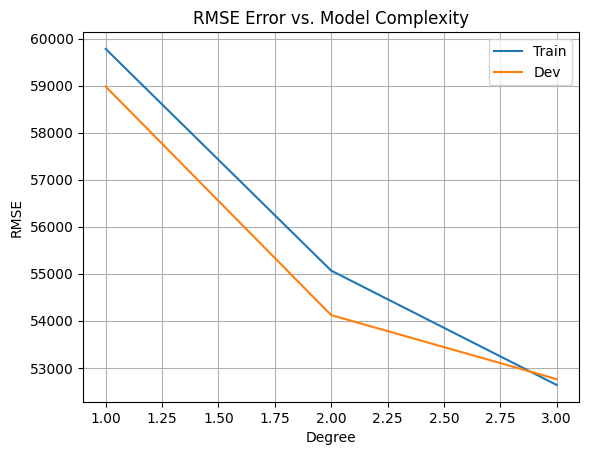

In [283]:
plt.plot(degrees, train_rmses, label="Train")
plt.plot(degrees, dev_rmses, label="Dev")
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE Error vs. Model Complexity")

### Scatter Plot of input data and fitted data

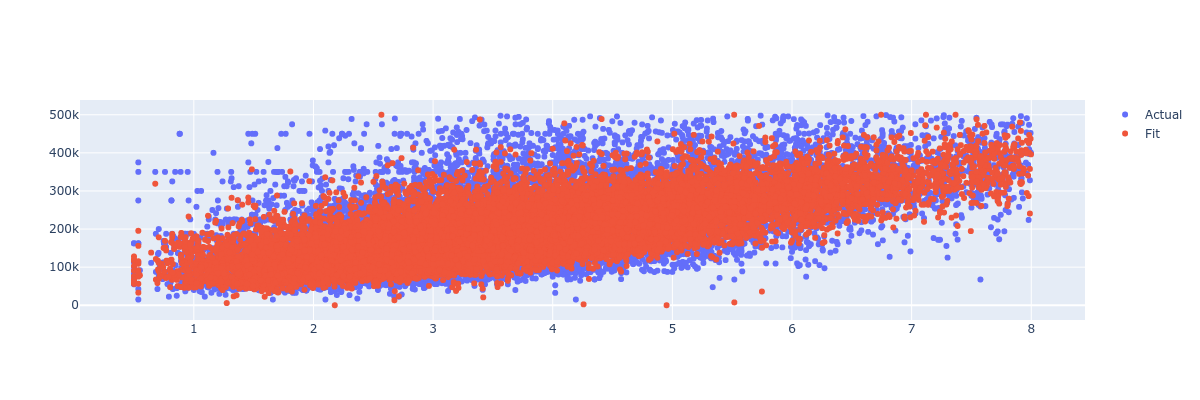

In [284]:
# Predict all
pred_all = clip(pipe.predict(df_fit[features]))

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_ocean["median_income"],
        y=df_ocean[target_name],
        mode="markers",
        name="Actual",
    )
)
fig.add_trace(
    go.Scatter(x=df_ocean[target_name], y=pred_all, mode="markers", name="Fit")
)

Image(fig.to_image(format="png", width=1200, height=400, scale=1))

# Permutation Importance